
# Lecture 23 - Prompt Engineering and Function Calling

*Important Note*:

Always verify model suggestions against trusted sources and follow laboratory safety rules. LLM responses are not a substitute for method validation, risk assessment, or supervisor approval.


## Learning goals

- Explain zero-shot, one-shot, and few-shot prompting in a chemistry setting.
- Use **structured prompts** and ask for **JSON** outputs for easier downstream processing.
- Call **tools** from prompts via simple function calling, then combine results back into a model response.


[![Colab](https://img.shields.io/badge/Open-Colab-orange)](https://colab.research.google.com/drive/18NZIvGg0hd0P5oOTwfQ61x9K3dS6qdU_?usp=sharing)



For this lecture 20, it is recommended to run everything in Colab.



## 1. Setup


In [ ]:
raise RuntimeError("Intentional stop: ending execution here.")

duckduckgo_search available.
scikit-learn loaded.






## 2. Zero-shot prompts for chemistry

As we learned in the previous lecture, **zero-shot** means we ask a question without giving examples. The model relies on general knowledge and the instructions in our prompt.


Just a recap on the concepts on LLMs we covered before:

- A modern model predicts the next token conditioned on previous tokens. A `token` is a unit of text similar to a word piece.  
- The model output depends on your `instructions`, the `examples` you include, and any `tools` you give it.  
- The **temperature** parameter controls randomness. Small values close to 0 are helpful for stable formats.  
- The **max output tokens** parameter bounds the length of the response. If you set it too low the model may truncate.  





**Rule of Thumb for Prompt Engineering**

When writing a zero-shot chemistry prompt, remember this simple rule of thumb:

1. Be explicit about what you want
2. Structured about how you want it
3. Chemical about why you want it

That means:

Explicit: Clearly state the goal (e.g., “Compute molar concentration in mol/L”).

Structured: Specify the required output format, (e.g., JSON, table, short answer within 5 words)

Chemical: Include the relevant context so the model can apply chemistry reasoning rather than guessing.

Further reading: *J. Am. Chem. Soc.* 2023, 145, 32, 18048–18062






### 2.1 Ask for a single value

Request: moles of ethanol in a volume at a given density. We also compute the reference answer in Python to compare later.

We will ask the model to answer with a JSON object. This format is easy to parse. Keep field names short and explicit.


In [98]:

# Reference calculation in pure Python
volume_ml = 50.0
density_g_per_ml = 0.789
mw_ethanol = 46.07  # g/mol
mass_g = volume_ml * density_g_per_ml
moles_ref = mass_g / mw_ethanol
print({"mass_g": round(mass_g, 4), "moles": round(moles_ref, 4)})


{'mass_g': 39.45, 'moles': 0.8563}


In [99]:

# Zero-shot prompt - live call only if client is configured
prompt = (
    """ Calculate moles of ethanol in 50 mL.
    Use density 0.789 g/mL and MW 46.07 g/mol.
    At the end, you start with **Answer:** and
    Return JSON with keys mass_g and moles with 4 decimals."""
)


resp = client.responses.create(model="gpt-4o", input=prompt)
print(resp.output_text)


To calculate the moles of ethanol in 50 mL, use the given density and molecular weight.

1. **Calculate the mass of ethanol:**
   \[
   \text{mass} = \text{volume} \times \text{density} = 50 \, \text{mL} \times 0.789 \, \text{g/mL} = 39.45 \, \text{g}
   \]

2. **Calculate the moles of ethanol:**
   \[
   \text{moles} = \frac{\text{mass}}{\text{molecular weight}} = \frac{39.45 \, \text{g}}{46.07 \, \text{g/mol}} \approx 0.8563 \, \text{mol}
   \]

**Answer:**

```json
{
  "mass_g": 39.4500,
  "moles": 0.8563
}
```


Why JSON for a single value? Even one number becomes easier to log, compare, and use in later steps if the format is stable. In a lab pipeline this reduces copy-paste errors.

Below is you see that if we suggest a *table* instead of JSON, sometimes it's hard to collect the answers across different calls as the format may differ slightly.

In [100]:
prompt_table = (
    """ Calculate moles of ethanol in 50 mL.
    Use density 0.789 g/mL and MW 46.07 g/mol.
    At the end, you start with **Answer:** and
    Return a table containing mass_g and moles with 4 decimals."""
)


for n in range(0,3):
  resp = client.responses.create(model="gpt-4o", input=prompt_table)
  print(f"\n Answer {n+1} ")
  print(resp.output_text)
  print("\n"*2)


 Answer 1 
To calculate the moles of ethanol in 50 mL, follow these steps:

1. **Calculate the mass of ethanol:**

   \[
   \text{mass} = \text{volume} \times \text{density} = 50 \, \text{mL} \times 0.789 \, \text{g/mL} = 39.45 \, \text{g}
   \]

2. **Calculate the moles of ethanol:**

   \[
   \text{moles} = \frac{\text{mass}}{\text{molar mass}} = \frac{39.45 \, \text{g}}{46.07 \, \text{g/mol}} = 0.8564 \, \text{moles}
   \]

**Answer:**

| mass_g | moles  |
|--------|--------|
| 39.4500 | 0.8564 |




 Answer 2 
To calculate the moles of ethanol in 50 mL, follow these steps:

1. **Calculate the mass:**
   \[
   \text{mass} = \text{density} \times \text{volume} = 0.789 \, \text{g/mL} \times 50 \, \text{mL} = 39.45 \, \text{g}
   \]

2. **Calculate the moles:**
   \[
   \text{moles} = \frac{\text{mass}}{\text{molar mass}} = \frac{39.45 \, \text{g}}{46.07 \, \text{g/mol}} \approx 0.8563 \, \text{mol}
   \]

**Answer:**

| mass\_g | moles  |
|---------|--------|
| 39.4500 | 0.8563 |






### 2.2 Request a list with structure

Chemists often want properties in a table. Ask for a list of small items and show the structure as a preview.


In [101]:
prompt = (
    "Give three physical properties of ethanol. "
    "Return a JSON list with objects having keys: name, value, unit, source."
)

resp = client.responses.create(model="gpt-4o", input=prompt, temperature=0)
print(resp.output_text)



```json
[
    {
        "name": "Boiling Point",
        "value": 78.37,
        "unit": "°C",
        "source": "NIST Chemistry WebBook"
    },
    {
        "name": "Density",
        "value": 0.789,
        "unit": "g/cm³",
        "source": "NIST Chemistry WebBook"
    },
    {
        "name": "Molecular Weight",
        "value": 46.07,
        "unit": "g/mol",
        "source": "NIST Chemistry WebBook"
    }
]
```



## 3. One-shot and few-shot patterns

**One-shot** gives a single example. **Few-shot** gives several. These examples define a template that the model mimics. We will parse a chemical name into **SMILES** and then classify short safety statements.

When giving examples keep them clear and compact. Do not load too many examples at once or the model may copy phrasing rather than follow the idea.



### 3.1 One-shot: name to SMILES

We show one input-output pair, then request a different compound with the same output shape. If RDKit is available, we validate the SMILES by constructing a molecule.


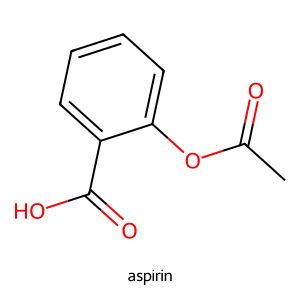

In [102]:

example_name = "aspirin"
example_smiles = "O=C(O)C1=CC=CC=C1OC(=O)C"  # a common representation
target_name = "paracetamol"

mol = Chem.MolFromSmiles(example_smiles)
Draw.MolToImage(mol, legend=example_name)


  Below, instead of just asking model to produce a JSON or Table, we show it what an output should look like.
  
  `{{"name":"{aspirin}","smiles":"{O=C(O)C1=CC=CC=C1OC(=O)C}"}}`

In [103]:
oneshot_prompt = '''
You convert chemical names to SMILES in JSON.
Example input: "{aspirin}"
Example output: {{"name":"{aspirin}","smiles":"{O=C(O)C1=CC=CC=C1OC(=O)C}"}}
Now convert: "{paracetamol}"
Return JSON with fields name and smiles only.
'''

resp = client.responses.create(model="gpt-4o", input=oneshot_prompt, temperature=0)
print(resp.output_text)


{{"name":"{paracetamol}","smiles":"{CC(=O)NC1=CC=C(C=C1)O}"}}


You can also use f-block to replace the examples in the prompt

In [104]:
example_name = "(S)-lactic acid"
example_smiles = "C[C@H](O)C(=O)O"
target_name = "L-alanine"


oneshot_prompt = f'''
You convert chemical names to SMILES in JSON.
Example input: "{example_name}"
Example output: {{"name":"{example_name}","smiles":"{example_smiles}"}}
Now convert: "{target_name}"
Return JSON with fields name and smiles only.
'''

resp = client.responses.create(model="gpt-4o", input=oneshot_prompt, temperature=0)
print(resp.output_text)



{"name":"L-alanine","smiles":"C[C@H](N)C(=O)O"}



Again, note that LLM can halluciate! Always verify the answer produced.




### 3.2 Few-shot: classify short safety statements

As you see below, we we do *few-shot*, we show possible inputs and the respective label outputs.

Few-shot design depends on the **selection** and **ordering** of examples. Guide rails:
- Use the good number of examples that removes ambiguity.  
- Begin with a **positive** example that shows the target format.  
- Include at least a few **counterexample** if the task has common traps. Mark it clearly with a reason field.  
- Use consistent formats across examples and queries.  
- When classes are imbalanced in your real data, consider including at least one rare class example so the model sees the pattern.

A simple scoring trick for example selection uses cosine similarity in an embedding space to pick examples that are close to the query but not identical. That method is outside the scope of this class but worth reading about.




Below task: mark each sentence as `ok_for_lab` or `needs_review`.


In [105]:

fewshot_instructions = (
    "Classify short safety statements. If the statement is uncertain or suggests a hazardous step without controls, "
    "mark as needs_review. Return JSON with fields text and label."
)
ex1 = {"text": "Wear splash goggles when handling concentrated acid.", "label": "ok_for_lab"}
ex2 = {"text": "Heat a sealed vessel vigorously without a pressure relief device.", "label": "needs_review"}
ex3 = {"text": "Dispose organic waste according to local rules.", "label": "ok_for_lab"}

query_items = [
    "Quench excess hydride with slow addition of isopropanol in an ice bath.",
    "Mix nitric acid and acetone in a closed container for storage.",
    "Use a blast shield during high pressure hydrogenation."
]

fewshot_prompt = f"""
{fewshot_instructions}
Examples:
{json.dumps(ex1)}
{json.dumps(ex2)}
{json.dumps(ex3)}
Now classify:
{json.dumps(query_items)}
"""


print(fewshot_prompt)


Classify short safety statements. If the statement is uncertain or suggests a hazardous step without controls, mark as needs_review. Return JSON with fields text and label.
Examples:
{"text": "Wear splash goggles when handling concentrated acid.", "label": "ok_for_lab"}
{"text": "Heat a sealed vessel vigorously without a pressure relief device.", "label": "needs_review"}
{"text": "Dispose organic waste according to local rules.", "label": "ok_for_lab"}
Now classify:
["Quench excess hydride with slow addition of isopropanol in an ice bath.", "Mix nitric acid and acetone in a closed container for storage.", "Use a blast shield during high pressure hydrogenation."]



Now let's see result:

In [106]:

resp = client.responses.create(model="gpt-4o", input=fewshot_prompt, temperature=0)
print(resp.output_text)

```json
[
    {"text": "Quench excess hydride with slow addition of isopropanol in an ice bath.", "label": "ok_for_lab"},
    {"text": "Mix nitric acid and acetone in a closed container for storage.", "label": "needs_review"},
    {"text": "Use a blast shield during high pressure hydrogenation.", "label": "ok_for_lab"}
]
```



## 5. Function calling: from prompt to tools


Function calling routes a prompt to a **tool**. The tool performs structured work and returns data that the model can use. We define small tools for unit conversions and RDKit descriptors, then invite the model to pick the right tool given a user question.

### 5.1 Tool specs for an LLM


You will see the tool specification as a JSON schema. In production you would keep schemas short and stable.


In [107]:
import requests, re
# Tool 1 - unit conversion
def grams_to_moles(mass_g: float, mw: float) -> float:
    return float(mass_g) / float(mw)

def moles_to_grams(moles: float, mw: float) -> float:
    return float(moles) * float(mw)

# Tool 2 - small RDKit descriptor set
def rdkit_basic(smiles: str) -> dict:
    mol = Chem.MolFromSmiles(smiles)
    return {
        "MolWt": Descriptors.MolWt(mol),
        "LogP": Crippen.MolLogP(mol),
        "TPSA": rdMolDescriptors.CalcTPSA(mol),
        "NumRings": rdMolDescriptors.CalcNumRings(mol),
    }

# Tool 3 - tiny search helper
def quick_search(query: str, max_results: int = 3):
    if max_results is None:
        max_results = 3  # default when model passes null (strict mode)
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{query}/JSON"
    try:
        r = requests.get(url, timeout=5)
        r.raise_for_status()
        data = r.json()
    except Exception:
        return []

    results = []
    compounds = data.get("PC_Compounds", [])
    for c in compounds[:max_results]:
        props = c.get("props", [])
        info = {"CID": c.get("id", {}).get("id", {}).get("cid")}
        for p in props:
            label = p.get("urn", {}).get("label", "")
            value = p.get("value", {})
            if "sval" in value:
                info[label] = value["sval"]
            elif "fval" in value:
                info[label] = value["fval"]
        results.append(info)
    return results

# Example
print(quick_search("ethanol safety data"))


print("Tool examples:")
print("grams_to_moles:", grams_to_moles(39.45, 46.07))
print("rdkit_basic:", rdkit_basic("CCO"))
print("quick_search:", quick_search("ethanol"))


[]
Tool examples:
grams_to_moles: 0.8563056218797482
rdkit_basic: {'MolWt': 46.069, 'LogP': -0.0014000000000000123, 'TPSA': 20.23, 'NumRings': 0}
quick_search: [{'CID': 702, 'Compound Complexity': 2.8, 'IUPAC Name': 'ethanol', 'InChI': 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3', 'InChIKey': 'LFQSCWFLJHTTHZ-UHFFFAOYSA-N', 'Log P': -0.1, 'Mass': '46.041864811', 'Molecular Formula': 'C2H6O', 'Molecular Weight': '46.07', 'SMILES': 'CCO', 'Topological': 20.2, 'Weight': '46.041864811'}]



## 5.2 Defining Function Specifications
Now, let's learn how we "teach" LLMs to use these functions we alreay have!

So, how do LLMs know **when** and **how** to call functions?

The short answer is we just write the definition for all function we have available locally.

Below is a compact schema description. Different SDKs have slightly different parameter names for function calling. The important piece is the argument schema and the tool name.


In [108]:
tools = [
    {
        "type": "function",
        "name": "grams_to_moles",
        "description": "Convert grams to moles given molecular weight in g/mol.",
        "strict": True,
        "parameters": {
            "type": "object",
            "additionalProperties": False,
            "properties": {
                "mass_g": {"type": "number", "description": "Mass in grams", "minimum": 0},
                "mw": {"type": "number", "description": "Molecular weight in g/mol", "exclusiveMinimum": 0}
            },
            "required": ["mass_g", "mw"]
        }
    },
    {
        "type": "function",
        "name": "moles_to_grams",
        "description": "Convert moles to grams given molecular weight in g/mol.",
        "strict": True,
        "parameters": {
            "type": "object",
            "additionalProperties": False,
            "properties": {
                "moles": {"type": "number", "description": "Amount in moles", "minimum": 0},
                "mw": {"type": "number", "description": "Molecular weight in g/mol", "exclusiveMinimum": 0}
            },
            "required": ["moles", "mw"]
        }
    },
    {
        "type": "function",
        "name": "rdkit_basic",
        "description": "Return MolWt, LogP, TPSA, and NumRings for a SMILES string.",
        "strict": True,
        "parameters": {
            "type": "object",
            "additionalProperties": False,
            "properties": {
                "smiles": {"type": "string", "description": "SMILES string"}
            },
            "required": ["smiles"]
        }
    },
    {
        "type": "function",
        "name": "quick_search",
        "description": "Search PubChem by compound name and return identifiers/properties (uses the 'name' endpoint).",
        "strict": True,
        "parameters": {
            "type": "object",
            "additionalProperties": False,
            "properties": {
                "query": {"type": "string", "description": "Compound name to search on PubChem"},
                # allow null so it's 'optional' but still listed in required (strict-mode pattern)
                "max_results": {"type": ["integer", "null"], "minimum": 1, "maximum": 50}
            },
            "required": ["query", "max_results"]
        }
    }
]


## 5.3 Example on `grams_to_moles`

Now, let's test with a simple case to calculate the moles of EtOH.

In [109]:
# Example 1
MODEL = "gpt-4o"
input_msgs = [{"role": "user", "content": "How many moles are in 39154151.45 g of ethanol if MW is 46.07 g/mol?"}]

# 1) Ask the model with tools
resp = client.responses.create(
    model=MODEL,
    input=input_msgs,
    tools=tools,
)

# 2) Execute any tool calls and append outputs
input_msgs += resp.output
for item in resp.output:
    if item.type == "function_call" and item.name == "grams_to_moles":
        args = json.loads(item.arguments)
        result = {"moles": grams_to_moles(**args)}
        input_msgs.append({
            "type": "function_call_output",
            "call_id": item.call_id,
            "output": json.dumps(result)
        })

# 3) Ask for final answer
final = client.responses.create(
    model=MODEL,
    input=input_msgs,
    tools=tools,
    instructions="Use the tool output and include units."
)

print(final.output_text)


There are approximately 849,883.90 moles in 39,154,151.45 g of ethanol.


Below code cell is showing you how the function-calling “scheme” (or flow) actually works under the hood in your Colab or notebook environment.

It has exactly same input as the one above, but we just add more print statements to show how this is done step by step.

In [110]:
# Example 1 — step by step trace
import json
from pprint import pprint

MODEL = "gpt-4o"

def _as_json(x):
    try:
        # OpenAI SDK objects usually have model_dump or model_dump_json
        if hasattr(x, "model_dump"):
            return x.model_dump()
        if hasattr(x, "model_dump_json"):
            return json.loads(x.model_dump_json())
    except Exception:
        pass
    try:
        return json.loads(json.dumps(x, default=lambda o: getattr(o, "__dict__", str(o))))
    except Exception:
        return str(x)

# Step 0: user input
input_msgs = [{"role": "user", "content": "How many moles are in 39154151.45 g of ethanol if MW is 46.07 g/mol?"}]
print("\n--- Step 0: User input ---")
pprint(input_msgs)

# Step 1: ask the model with tools
resp = client.responses.create(
    model=MODEL,
    input=input_msgs,
    tools=tools,
    parallel_tool_calls=False,
    tool_choice="auto",
)

print("\n--- Step 1: Model output items ---")
for idx, item in enumerate(resp.output):
    j = _as_json(item)
    print(f"[output {idx}] type={j.get('type')}, name={j.get('name')}")
    if j.get("type") == "function_call":
        print("  arguments:", j.get("arguments"))

# Keep a running transcript like the docs
input_msgs += resp.output

# Step 2: execute any tool calls and append outputs
print("\n--- Step 2: Executing tool calls ---")
made_call = False
for item in resp.output:
    if getattr(item, "type", None) == "function_call" and item.name == "grams_to_moles":
        made_call = True
        args = json.loads(item.arguments or "{}")
        print("Function called: grams_to_moles")
        print("Arguments:", args)

        result_obj = {"moles": grams_to_moles(**args)}
        result_json = json.dumps(result_obj)

        print("Tool result:", result_obj)

        # Append function_call_output for this call_id
        input_msgs.append({
            "type": "function_call_output",
            "call_id": item.call_id,
            "output": result_json
        })

if not made_call:
    print("No function_call received. You can force it with tool_choice={'type':'function','name':'grams_to_moles'}.")

print("\n--- Step 2b: Messages after appending tool output ---")
pprint([_as_json(m) for m in input_msgs])

# Step 3: ask for final answer (second round)
final = client.responses.create(
    model=MODEL,
    input=input_msgs,
    tools=tools,
    instructions="Use the tool output and include units."
)

print("\n--- Step 3: Final response object (summary) ---")
print(final.output_text)

# Optional: show raw items from the final response
print("\n--- Step 3b: Final response raw items ---")
for idx, item in enumerate(final.output):
    j = _as_json(item)
    print(f"[final {idx}] type={j.get('type')}")
    if j.get("type") == "message":
        # typical text message content is in output_text, but show the item too
        pprint(j)



--- Step 0: User input ---
[{'content': 'How many moles are in 39154151.45 g of ethanol if MW is 46.07 '
             'g/mol?',
  'role': 'user'}]

--- Step 1: Model output items ---
[output 0] type=function_call, name=grams_to_moles
  arguments: {"mass_g":39154151.45,"mw":46.07}

--- Step 2: Executing tool calls ---
Function called: grams_to_moles
Arguments: {'mass_g': 39154151.45, 'mw': 46.07}
Tool result: {'moles': 849883.9038419797}

--- Step 2b: Messages after appending tool output ---
[{'content': 'How many moles are in 39154151.45 g of ethanol if MW is 46.07 '
             'g/mol?',
  'role': 'user'},
 {'arguments': '{"mass_g":39154151.45,"mw":46.07}',
  'call_id': 'call_5hTDLfSW1OmrDIiPBi54xTSh',
  'id': 'fc_0a45f5bd9e695af9006910c41d77e081909c44bb99a9533f80',
  'name': 'grams_to_moles',
  'status': 'completed',
  'type': 'function_call'},
 {'call_id': 'call_5hTDLfSW1OmrDIiPBi54xTSh',
  'output': '{"moles": 849883.9038419797}',
  'type': 'function_call_output'}]

--- Step 3: F

## 5.4 Example on `rdkit_basic`

In [111]:
# Cell 3: Example 2

input_msgs = [{"role": "user", "content": "Give MolWt, LogP, TPSA, and NumRings for ethanol, SMILES CCO."}]

resp = client.responses.create(
    model=MODEL,
    input=input_msgs,
    tools=tools,
)

input_msgs += resp.output
for item in resp.output:
    #print(item)    #Uncomment this one to see model's decision
    if item.type == "function_call" and item.name == "rdkit_basic":
        #print(item.arguments)   #Uncomment this one to see what model decides to input for the function
        args = json.loads(item.arguments)
        result = rdkit_basic(**args)
        input_msgs.append({
            "type": "function_call_output",
            "call_id": item.call_id,
            "output": json.dumps(result)
        })

final = client.responses.create(
    model=MODEL,
    input=input_msgs,
    tools=tools,
    #instructions="Summarize the descriptor values clearly." #This user input is optional
)

print(final.output_text)


Here are the properties of ethanol (SMILES: CCO):

- **Molecular Weight (MolWt):** 46.069 g/mol
- **LogP:** -0.0014
- **Topological Polar Surface Area (TPSA):** 20.23 Å²
- **Number of Rings (NumRings):** 0


## 5.5 Example on PubChem search

In [112]:
# Cell 4: Example 3

input_msgs = [{"role": "user", "content": "Find asprin on PubChem by name and give IUPAC name, MW, formula."}]

resp = client.responses.create(
    model=MODEL,
    input=input_msgs,
    tools=tools,
)

input_msgs += resp.output
for item in resp.output:
    if item.type == "function_call" and item.name == "quick_search":
        args = json.loads(item.arguments)
        result = {"results": quick_search(**args)}
        input_msgs.append({
            "type": "function_call_output",
            "call_id": item.call_id,
            "output": json.dumps(result)
        })

final = client.responses.create(
    model=MODEL,
    input=input_msgs,
    tools=tools,
)

print(final.output_text)


Aspirin has the following chemical properties:

- **IUPAC Name**: 2-acetoxybenzoic acid
- **Molecular Weight**: 180.16 g/mol
- **Molecular Formula**: C₉H₈O₄


## 5.6 Using multiple tools in one conversation

In [113]:
# Multi-tool loop: the model can keep calling tools until no more function_call items appear.
# Assumes you already defined: client, MODEL, tools, grams_to_moles, moles_to_grams, rdkit_basic, quick_search

prompt = (
    "I have 9,999,992.14 g of asprin, and I do not know its molecular weight. "
    "Look up the MW online and convert that to moles. "
)

messages = [{"role": "user", "content": prompt}]

round_idx = 0
while True:
    round_idx += 1
    print(f"\n===== Round {round_idx}: model call =====")
    resp = client.responses.create(
        model=MODEL,            # e.g., "gpt-4o"
        input=messages,
        tools=tools,
        parallel_tool_calls=True,     # allow multiple tool calls per turn
        tool_choice="auto",           # let the model decide,
    )

    # Show what the model returned this round
    for i, item in enumerate(resp.output):
        t = getattr(item, "type", None)
        name = getattr(item, "name", "")
        print(f"[item {i}] type={t} {('name='+name) if name else ''}")
        if t == "function_call":
            print("  arguments:", item.arguments)

    # Add the model output to the transcript
    messages += resp.output

    # Execute any tool calls we received
    made_any_call = False
    for item in resp.output:
        if getattr(item, "type", None) != "function_call":
            continue

        made_any_call = True
        tool_name = item.name
        args = json.loads(item.arguments or "{}")
        print(f"\nExecuting tool: {tool_name}")
        print("Arguments:", args)

        try:
            if tool_name == "grams_to_moles":
                result = {"moles": grams_to_moles(**args)}
            elif tool_name == "moles_to_grams":
                result = {"grams": moles_to_grams(**args)}
            elif tool_name == "rdkit_basic":
                result = rdkit_basic(**args)
            elif tool_name == "quick_search":
                # strict-mode pattern may send null; treat None as default
                if "max_results" in args and args["max_results"] is None:
                    args["max_results"] = 3
                result = {"results": quick_search(**args)}
            else:
                result = {"ok": False, "error": f"Unknown tool {tool_name}"}
        except Exception as e:
            result = {"ok": False, "error": str(e)}

        print("Tool output:")
        pprint(result)

        # Append tool output back to the conversation for the model to use next round
        messages.append({
            "type": "function_call_output",
            "call_id": item.call_id,
            "output": json.dumps(result)
        })

    # If no tools were requested this round, we are done and can show the final text
    if not made_any_call:
        print("\n===== Final response =====")
        print(resp.output_text)
        break



===== Round 1: model call =====
[item 0] type=function_call name=quick_search
  arguments: {"query":"aspirin","max_results":1}

Executing tool: quick_search
Arguments: {'query': 'aspirin', 'max_results': 1}
Tool output:
{'results': [{'CID': 2244,
              'Compound Complexity': 212,
              'IUPAC Name': '2-acetoxybenzoic acid',
              'InChI': 'InChI=1S/C9H8O4/c1-6(10)13-8-5-3-2-4-7(8)9(11)12/h2-5H,1H3,(H,11,12)',
              'InChIKey': 'BSYNRYMUTXBXSQ-UHFFFAOYSA-N',
              'Log P': 1.2,
              'Mass': '180.04225873',
              'Molecular Formula': 'C9H8O4',
              'Molecular Weight': '180.16',
              'SMILES': 'CC(=O)OC1=CC=CC=C1C(=O)O',
              'Topological': 63.6,
              'Weight': '180.04225873'}]}

===== Round 2: model call =====
[item 0] type=function_call name=grams_to_moles
  arguments: {"mass_g":9999992.14,"mw":180.16}

Executing tool: grams_to_moles
Arguments: {'mass_g': 9999992.14, 'mw': 180.16}
Tool output:


Below is a summary of function caling workflow:

Credit: OpenAI

Further reading: https://platform.openai.com/docs/guides/function-calling

In [114]:
from IPython.display import Image, display
display(Image(url = "https://cdn.openai.com/API/docs/images/function-calling-diagram-steps.png",    width=600, height=800))


## 5.7 Use a pre-trained model as a tool

Many labs fit scikit-learn models to predict properties. Here we train a small random forest on a chemistry dataset, then expose a function `rf_predict` that the model can call. This turns a model into a tool in the same style as unit converters. We reuse the **C_H_oxidation_dataset.csv** from Lecture 7.


In [115]:

url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv"
df_raw = pd.read_csv(url)
print("Loaded rows:", len(df_raw))
display(df_raw.head(3))

def calc_desc(smiles):
  mol = Chem.MolFromSmiles(smiles)
  return pd.Series({"MolWt": Descriptors.MolWt(mol),
                "LogP": Crippen.MolLogP(mol),
                "TPSA": rdMolDescriptors.CalcTPSA(mol),
                "NumRings": rdMolDescriptors.CalcNumRings(mol)})

desc = df_raw["SMILES"].apply(calc_desc)
df_model = pd.concat([df_raw, desc], axis=1)
print("Columns:", list(df_model.columns)[:10], "...")
display(df_model.head(2))

Loaded rows: 575


,Compound Name,CAS,SMILES,Solubility_mol_per_L,pKa,Toxicity,Melting Point,Reactivity,Oxidation Site
0,"3,4-dihydro-1H-isochromene",493-05-0,c1ccc2c(c1)CCOC2,0.103906,5.80,non_toxic,65.8,1,"8,10"
1,9H-fluorene,86-73-7,c1ccc2c(c1)Cc1ccccc1-2,0.010460,5.82,toxic,90.0,1,7
2,"1,2,3,4-tetrahydronaphthalene",119-64-2,c1ccc2c(c1)CCCC2,0.020589,5.74,toxic,69.4,1,"7,10"


Columns: ['Compound Name', 'CAS', 'SMILES', 'Solubility_mol_per_L', 'pKa', 'Toxicity', 'Melting Point', 'Reactivity', 'Oxidation Site', 'MolWt'] ...


,Compound Name,CAS,SMILES,Solubility_mol_per_L,pKa,Toxicity,Melting Point,Reactivity,Oxidation Site,MolWt,LogP,TPSA,NumRings
0,"3,4-dihydro-1H-isochromene",493-05-0,c1ccc2c(c1)CCOC2,0.103906,5.80,non_toxic,65.8,1,"8,10",134.178,1.7593,9.23,2.0
1,9H-fluorene,86-73-7,c1ccc2c(c1)Cc1ccccc1-2,0.010460,5.82,toxic,90.0,1,7,166.223,3.2578,0.00,3.0



Now we train a small random forest. For demo purpose, we use a simple target such as **Melting Point**.

In [116]:

base_feats = ["MolWt", "LogP", "TPSA", "NumRings"]

# Compute descriptors if missing
if not set(base_feats).issubset(df_model.columns):
    desc_df = df_model["SMILES"].apply(rdkit_basic).apply(pd.Series)
    df_model = pd.concat([df_model, desc_df], axis=1)

# Prepare target as 1/0
lab = (
    df_model["Toxicity"].astype(str).str.strip().str.lower().str.replace("-", "_")
)
label_map = {"toxic": 1, "non_toxic": 0}
df_model["_tox"] = lab.map(label_map)

# Clean rows
use_cols = base_feats + ["_tox"]
data = df_model.dropna(subset=use_cols)

X = data[base_feats].to_numpy(dtype=float)
y = data["_tox"].to_numpy(dtype=int)

#Split, Train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

clf = RandomForestClassifier(n_estimators=300, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}  F1: {f1_score(y_test, y_pred):.3f}")

Accuracy: 0.965  F1: 0.979


Now we wrap a SMILES toxicity predictor

In [117]:
FEATURES_USED = base_feats  # keep the order for inference

def predict_toxicity_from_smiles(smiles: str):
  # SMILES -> descriptors -> toxicity prediction

    if "clf" not in globals() or clf is None:
        return {"ok": False, "error": "Classifier not trained."}

    desc = rdkit_basic(smiles)

    x = np.array([desc[k] for k in FEATURES_USED], dtype=float).reshape(1, -1)
    proba = float(clf.predict_proba(x)[0, 1])
    label = "toxic" if proba >= 0.5 else "non_toxic"

    return {
        "ok": True,
        "input": {"smiles": smiles},
        "descriptors": {k: desc[k] for k in FEATURES_USED},
        "features_used": FEATURES_USED,
        "prediction": {"label": label, "probability": proba}
    }


predict_toxicity_from_smiles("COO")

{'ok': True,
 'input': {'smiles': 'COO'},
 'descriptors': {'MolWt': 48.041000000000004,
  'LogP': 0.10580000000000006,
  'TPSA': 29.46,
  'NumRings': 0},
 'features_used': ['MolWt', 'LogP', 'TPSA', 'NumRings'],
 'prediction': {'label': 'non_toxic', 'probability': 0.06}}

Similarly, we need to write tool specifications so later LLMs will know how to use it.

In [118]:
tox_tool = {
    "type": "function",
    "name": "predict_toxicity_from_smiles",
    "description": "Given a SMILES, compute RDKit descriptors and predict toxicity (toxic/non_toxic) using the trained classifier.",
    "strict": True,
    "parameters": {
        "type": "object",
        "additionalProperties": False,
        "properties": {
            "smiles": {"type": "string", "description": "Input SMILES string"}
        },
        "required": ["smiles"]
    }
}

tools = [tox_tool]

Now we can ask LLMs questions, and they will use our in-house functions to make predictions and interpret the answers.

In [119]:


user_msg = "Is Lactic acid toxic? How likely?"

messages = [{"role": "user", "content": user_msg}]

# Round 1: model decides to call the tool
resp1 = client.responses.create(
    model=MODEL,
    input=messages,
    tools=tools,
    parallel_tool_calls=False,
    tool_choice="auto",
)

messages += resp1.output

# Execute tool calls and append outputs
for item in resp1.output:
    if getattr(item, "type", None) == "function_call" and item.name == "predict_toxicity_from_smiles":
        args = json.loads(item.arguments or "{}")
        out = predict_toxicity_from_smiles(**args)
        messages.append({
            "type": "function_call_output",
            "call_id": item.call_id,
            "output": json.dumps(out)
        })

# Round 2: final answer
resp2 = client.responses.create(
    model=MODEL,
    input=messages,
    tools=tools,
)

print(resp2.output_text)

Lactic acid is predicted to be non-toxic with a probability of 7%.


Now, we cab combine in-house functions together with search tools and do function callings. In this case, you just ask questions in human natural languge, the LLM help search for the SMILES notations and put it to the ML tools for prediction.

In [120]:
search_tool ={
        "type": "function",
        "name": "quick_search",
        "description": "Search PubChem by compound name and return identifiers/properties. Use this to find a SMILES.",
        "strict": True,
        "parameters": {
            "type": "object",
            "additionalProperties": False,
            "properties": {
                "query": {"type": "string", "description": "Compound name to search on PubChem"}
            },
            "required": ["query"]
    }
}


tools = [tox_tool, search_tool]

# ---- Conversation loop ----
prompt = (
    "What is the toxicity for EGFR inhibitor? Do not guess."
)

messages = [{"role": "user", "content": prompt}]

round_idx = 0
while True:
    round_idx += 1
    print(f"\n===== Round {round_idx} =====")
    resp = client.responses.create(
        model=MODEL,
        input=messages,
        tools=tools,
        parallel_tool_calls=False,   # encourage two rounds: search then predict
        tool_choice="auto",
    )

    # Inspect model outputs
    for i, item in enumerate(resp.output):
        t = getattr(item, "type", None)
        name = getattr(item, "name", "")
        print(f"[item {i}] type={t} {('name='+name) if name else ''}")
        if t == "function_call":
            print("  arguments:", item.arguments)

    # Add model output to the thread
    messages += resp.output

    # Execute tool calls
    made_call = False
    for item in resp.output:
        if getattr(item, "type", None) != "function_call":
            continue
        made_call = True
        args = json.loads(item.arguments or "{}")

        if item.name == "quick_search":
            # Use your existing quick_search() directly
            out = {"results": quick_search(**args)}
        elif item.name == "predict_toxicity_from_smiles":
            out = predict_toxicity_from_smiles(**args)
        else:
            out = {"ok": False, "error": f"Unknown tool {item.name}"}

        print("Tool output:")
        pprint(out)

        messages.append({
            "type": "function_call_output",
            "call_id": item.call_id,
            "output": json.dumps(out)
        })

    # Stop when model stops calling tools
    if not made_call:
        print("\n===== Final =====")
        print(resp.output_text)
        break


===== Round 1 =====
[item 0] type=function_call name=quick_search
  arguments: {"query":"EGFR inhibitor"}
Tool output:
{'results': [{'CID': 9549299,
              'Compound Complexity': 585,
              'IUPAC Name': 'N-[3-[[6-[3-(trifluoromethyl)anilino]pyrimidin-4-yl]amino]phenyl]cyclopropanecarboxamide',
              'InChI': 'InChI=1S/C21H18F3N5O/c22-21(23,24)14-3-1-4-15(9-14)27-18-11-19(26-12-25-18)28-16-5-2-6-17(10-16)29-20(30)13-7-8-13/h1-6,9-13H,7-8H2,(H,29,30)(H2,25,26,27,28)',
              'InChIKey': 'YOHYSYJDKVYCJI-UHFFFAOYSA-N',
              'Log P': 4.5,
              'Mass': '413.14634470',
              'Molecular Formula': 'C21H18F3N5O',
              'Molecular Weight': '413.4',
              'SMILES': 'C1CC1C(=O)NC2=CC=CC(=C2)NC3=NC=NC(=C3)NC4=CC=CC(=C4)C(F)(F)F',
              'Topological': 78.9,
              'Weight': '413.14634470'}]}

===== Round 2 =====
[item 0] type=function_call name=predict_toxicity_from_smiles
  arguments: {"smiles":"C1CC1C(=O)NC2=CC


## 6. Glossary

- **Zero-shot**: a prompt with no examples. The request must define the desired shape and scope.
- **One-shot**: a prompt with one example. The model mimics the pattern in your example.
- **Few-shot**: a prompt with several examples. Use when a single example is not enough to pin down the pattern.
- **Function calling**: a feature that lets a model request a tool with structured arguments and consume the tool output.
- **Schema**: a compact specification of argument names and types for a tool. Usually a JSON object with required fields.
- **JSON**: a plain data format for predictable programmatic parsing.
